In [2]:
#Hello this the test file
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Rescaling,InputLayer, regularization
from keras.layers import Conv2D, MaxPool2D, Input
import matplotlib.pylab as plt
from tensorflow.python.client import device_lib
from keras.callbacks import CSVLogger
from keras.utils import plot_model
from keras.regularizers import l2 # ridge regression
from keras.regularizers import l1 # lasso regression

from keras.optimizers import Adam, SGD, RMSprop, Adamax
from keras import mixed_precision
import pandas as pd
import numpy as np
import os
import sys

# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)

In [5]:
def convert_sample(sample):
    #alternativ use
    #image, label = sample['image'], sample['label']
    image = sample['image']
    label = sample['label']
    image = tf.image.convert_image_dtype(image, tf.float32)
    label =tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

# print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# gpu_available = tf.test.is_gpu_available()

# is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)

# is_cuda_gpu_min_3 = tf.test.is_gpu_available(True, (3,0))

# device_lib.list_local_devices()
# print(tf. version) 

# print("if true, GPU lives: ",tf.test.is_built_with_cuda())
file_dir = os.path.realpath(os.path.dirname('__file__'))


In [6]:
ds1,ds2,ds3 = tfds.load('patch_camelyon',split=['train[:20%]','test[:5%]','validation[:1%]'],
                        data_dir = file_dir,
                        download=False,
                        shuffle_files=True)

In [7]:
tf.keras.backend.clear_session()
train_ds = ds1.map(convert_sample).batch(256)
test_ds = ds2.map(convert_sample).batch(256)
val_ds = ds3.map(convert_sample).batch(256)

# bbatch prøvet med 32
# batch prøvet med 64

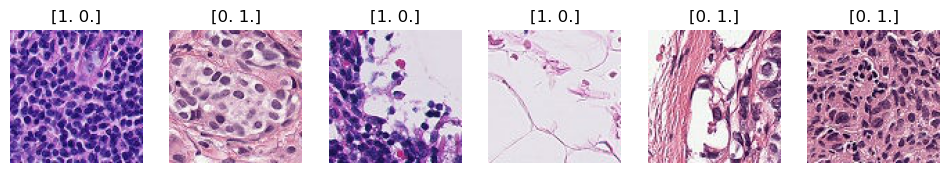

In [21]:
plt.figure(figsize=(12, 12))
for images, labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(1, 6, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(labels[i].numpy())
        plt.axis("off")

# Ny sektion

In [6]:
import tensorflow.experimental.numpy as tnp
tnp.experimental_enable_numpy_behavior()

def initialize_weights(input_nodes: int, default_zoom: float):
    biases = np.zeros((2, 3), dtype='float32')
    biases[0, 0] = default_zoom
    biases[1, 1] = default_zoom
    weights = np.zeros((input_nodes, 6), dtype='float32')
    
    return [weights, biases.flatten()]

In [7]:

import tensorflow as tf

from tensorflow.keras import backend as K

class BilinearInterpolation(tf.keras.layers.Layer):
    '''
    Used to construct Spatial Transformer Networks with Keras.

    See Spatial Transformer Networks, Max Jaderberg, et al.

    Based on https://github.com/oarriaga/STN.keras, with only very minor
    changes.

    '''

    def __init__(self, output_size: tuple, **kwargs):
        assert len(output_size) == 2
        for e in output_size:
            assert isinstance(e, int) and e > 0

        super(BilinearInterpolation, self).__init__(**kwargs)
        self.output_size = output_size

    def get_config(self):
        return {'output_size': self.output_size}

    def compute_output_shape(self, input_shape):
        height, width = self.output_size
        num_channels = input_shape[0][-1]

        return None, height, width, num_channels

    def call(self, inputs, **kwargs):
        X, transformation = inputs
        output = self._transform(X, transformation, self.output_size)

        return output

    def _interpolate(self, image, sampled_grids, output_size):
        batch_size = K.shape(image)[0]
        height = K.shape(image)[1]
        width = K.shape(image)[2]
        num_channels = K.shape(image)[3]

        x = K.cast(K.flatten(sampled_grids[:, 0:1, :]), dtype='float32')
        y = K.cast(K.flatten(sampled_grids[:, 1:2, :]), dtype='float32')

        x = .5 * (x + 1.0) * K.cast(width, dtype='float32')
        y = .5 * (y + 1.0) * K.cast(height, dtype='float32')

        x0 = K.cast(x, 'int32')
        x1 = x0 + 1
        y0 = K.cast(y, 'int32')
        y1 = y0 + 1

        max_x = int(K.int_shape(image)[2] - 1)
        max_y = int(K.int_shape(image)[1] - 1)

        x0 = K.clip(x0, 0, max_x)
        x1 = K.clip(x1, 0, max_x)
        y0 = K.clip(y0, 0, max_y)
        y1 = K.clip(y1, 0, max_y)

        pixels_batch = K.arange(0, batch_size) * (height * width)
        pixels_batch = K.expand_dims(pixels_batch, axis=-1)
        flat_output_size = output_size[0] * output_size[1]
        base = K.repeat_elements(pixels_batch, flat_output_size, axis=1)
        base = K.flatten(base)

        # base_y0 = base + (y0 * width)
        base_y0 = y0 * width
        base_y0 = base + base_y0
        # base_y1 = base + (y1 * width)
        base_y1 = y1 * width
        base_y1 = base_y1 + base

        indices_a = base_y0 + x0
        indices_b = base_y1 + x0
        indices_c = base_y0 + x1
        indices_d = base_y1 + x1

        flat_image = K.reshape(image, shape=(-1, num_channels))
        flat_image = K.cast(flat_image, dtype='float32')
        pixel_values_a = K.gather(flat_image, indices_a)
        pixel_values_b = K.gather(flat_image, indices_b)
        pixel_values_c = K.gather(flat_image, indices_c)
        pixel_values_d = K.gather(flat_image, indices_d)

        x0 = K.cast(x0, 'float32')
        x1 = K.cast(x1, 'float32')
        y0 = K.cast(y0, 'float32')
        y1 = K.cast(y1, 'float32')

        area_a = K.expand_dims(((x1 - x) * (y1 - y)), 1)
        area_b = K.expand_dims(((x1 - x) * (y - y0)), 1)
        area_c = K.expand_dims(((x - x0) * (y1 - y)), 1)
        area_d = K.expand_dims(((x - x0) * (y - y0)), 1)

        values_a = area_a * pixel_values_a
        values_b = area_b * pixel_values_b
        values_c = area_c * pixel_values_c
        values_d = area_d * pixel_values_d

        return values_a + values_b + values_c + values_d

    def _make_regular_grids(self, batch_size, height, width):
        # making a single regular grid
        x_linspace = tf.linspace(-1., 1., width)
        y_linspace = tf.linspace(-1., 1., height)
        x_coordinates, y_coordinates = tf.meshgrid(x_linspace, y_linspace)
        x_coordinates = K.flatten(x_coordinates)
        y_coordinates = K.flatten(y_coordinates)
        ones = K.ones_like(x_coordinates)
        grid = K.concatenate([x_coordinates, y_coordinates, ones], 0)

        # repeating grids for each batch
        grid = K.flatten(grid)
        grids = K.tile(grid, K.stack([batch_size]))

        return K.reshape(grids, (batch_size, 3, height * width))

    def _transform(self, X, affine_transformation, output_size):
        batch_size, num_channels = K.shape(X)[0], K.shape(X)[3]
        transformations = K.reshape(
            affine_transformation,
            shape=(batch_size, 2, 3),
            )
        # transformations = K.cast(affine_transformation[:, 0:2, :], 'float32')
        regular_grids = self._make_regular_grids(batch_size, *output_size)
        sampled_grids = K.batch_dot(transformations, regular_grids)
        interpolated_image = self._interpolate(X, sampled_grids, output_size)
        new_shape = (batch_size, output_size[0], output_size[1], num_channels)
        interpolated_image = K.reshape(interpolated_image, new_shape)

        return interpolated_image


if __name__ == '__main__':
    pass


In [8]:
for images, labels in train_ds.take(1): # hiv et tensor object med 32 images ud af batch datasættet
    true_pos_label_idx = [int(label.numpy()[1]) for label in labels].index(1) # find et image med en tumor <------LIGE HER
    image = images[true_pos_label_idx] # hiv image ud af batch tensor
    label = int(labels[true_pos_label_idx].numpy()[1]) # hiv label ud af batch tensor <----------- og HER

In [15]:
# Spatial transorner network

tf.keras.backend.clear_session()

# from layers import BilinearInterpolation


def set_initial_weights(input_nodes: int, set_zoom: float):
    bias = np.zeros((2,3), dtype = 'float32')
    
    bias[0, 0] = set_zoom
    bias[1, 1] = set_zoom

    weights = np.zeros((input_nodes, 6), dtype = 'float32')

    return [weights, bias.flatten()]

def build_loc_model(default_zoom):
    loc_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(8, kernel_size=5),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(10, kernel_size=3),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'), # 32 must match the below function call
        tf.keras.layers.Dense(6, activation='linear', 
                              weights=initialize_weights(32, default_zoom)),
        ])
    
    return loc_model

def build_cnn_model(sampling_shape, num_classes):
    cnn_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(10, kernel_size=3),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(20, kernel_size=5),
        tf.keras.layers.SpatialDropout2D(0.2),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
        ], name='classifier')
    
    return cnn_model


def build_stn_model(input_shape, sampling_shape, num_classes, default_zoom):
    loc_model = build_loc_model(default_zoom)
    cnn_model = build_cnn_model(sampling_shape, num_classes)
    
    image = tf.keras.layers.Input(shape=(input_shape))
    x = loc_model(image)
    x = BilinearInterpolation(sampling_shape)([image, x])    
    spatial_transform = tf.keras.models.Model(
        inputs=image, outputs=x, name='spatial_transformer',
    )

    stn_model = tf.keras.models.Sequential([
        spatial_transform,
        cnn_model,
        ])
    
    return stn_model
enlarged_shape = (96, 96)

stn_model = build_stn_model((*enlarged_shape, 3), (64, 64), 2, 1.0)
stn_model_zoom = build_stn_model((*enlarged_shape, 3), (64, 64), 2, 0.8)
imgs = []
for images, labels in train_ds.take(1):
    for i in range(3):
        img = images[i+1].numpy()
        img = np.expand_dims(img, axis=0)
        imgs.append(img)

out_pre_train = tnp.asarray(stn_model.get_layer('spatial_transformer')(imgs[0:1]))[0][:, :, 0]
out_pre_train_zoom = tnp.asarray(stn_model_zoom.get_layer('spatial_transformer')(imgs[0:1]))[0][:,:,0]

stn_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy'
,metrics=['accuracy'],)
stn_model_zoom.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy'
,metrics=['accuracy'],)

hist_stn = stn_model.fit(train_ds,
                     validation_data= val_ds,
                     epochs=30,
                     verbose=1,
                     )

hist_stn_zoom = stn_model_zoom.fit(train_ds,
                               validation_data=val_ds,
                               epochs=30,
                               verbose=1,
                               )

out_post_train = tnp.asarray(stn_model.get_layer('spatial_transformer')(imgs[0:1]))[0][:, :, 0]
out_post_train_zoom = tnp.asarray(stn_model_zoom.get_layer('spatial_transformer')(imgs[0:1]))[0][:,:,0]



Epoch 1/30
205/205 [==============================] - 15s 67ms/step - loss: 0.7338 - accuracy: 0.6362 - val_loss: 0.5799 - val_accuracy: 0.7561
Epoch 2/30
205/205 [==============================] - 14s 67ms/step - loss: 0.5932 - accuracy: 0.7366 - val_loss: 0.5418 - val_accuracy: 0.7439
Epoch 3/30
205/205 [==============================] - 14s 66ms/step - loss: 0.5514 - accuracy: 0.7531 - val_loss: 0.5274 - val_accuracy: 0.7744
Epoch 4/30
205/205 [==============================] - 14s 67ms/step - loss: 0.5351 - accuracy: 0.7558 - val_loss: 0.5224 - val_accuracy: 0.7591
Epoch 5/30
205/205 [==============================] - 14s 66ms/step - loss: 0.5209 - accuracy: 0.7673 - val_loss: 0.4357 - val_accuracy: 0.8049
Epoch 6/30
205/205 [==============================] - 14s 66ms/step - loss: 0.5362 - accuracy: 0.7510 - val_loss: 0.5705 - val_accuracy: 0.6921
Epoch 7/30
205/205 [==============================] - 14s 68ms/step - loss: 0.5774 - accuracy: 0.7001 - val_loss: 0.4667 - val_accuracy:

In [16]:
tf.keras.models.save_model(stn_model,  file_dir+'\\STN',
    save_format='tf', include_optimizer=True)

tf.keras.models.save_model(stn_model_zoom,  file_dir+'\\STN_zoom',
    save_format='tf', include_optimizer=True)

df_stn = pd.DataFrame(hist_stn.history)
df_stn_zoom = pd.DataFrame(hist_stn_zoom.history)

df_stn['epoch'] = df_stn.index +1
df_stn_zoom['epoch'] = df_stn_zoom.index +1

df_stn.to_csv('stn.csv', index=False)
df_stn_zoom.to_csv('stn_zoom.csv', index=False)


INFO:tensorflow:Assets written to: C:\Users\mikae\Anvendt maskinelearing eksamen\STN\assets


INFO:tensorflow:Assets written to: C:\Users\mikae\Anvendt maskinelearing eksamen\STN\assets


INFO:tensorflow:Assets written to: C:\Users\mikae\Anvendt maskinelearing eksamen\STN_zoom\assets


INFO:tensorflow:Assets written to: C:\Users\mikae\Anvendt maskinelearing eksamen\STN_zoom\assets


In [ ]:
#Plot df_stn accuracy and loss
df_stn = pd.read_csv('stn.csv')
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(df_stn['epoch'], df_stn['accuracy'], label='Training Accuracy')
plt.plot(df_stn['epoch'], df_stn['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xticks(np.arange(1, 30, 2))
plt.title('Accuracy STN no zoom')
plt.xlabel('epoch')

plt.subplot(1, 2, 1)
plt.plot(df_stn['epoch'], df_stn['loss'], label='Training Loss')
plt.plot(df_stn['epoch'], df_stn['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xticks(np.arange(1, 30, 2))
plt.title('Loss STN no zoom')
plt.xlabel('epoch')
plt.show()


In [ ]:
#plot df_stn_zoom accuracy and loss
df_stn_zoom = pd.read_csv('stn_zoom.csv')
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(df_stn_zoom['epoch'], df_stn_zoom['accuracy'], label='Training Accuracy')
plt.plot(df_stn_zoom['epoch'], df_stn_zoom['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.xticks(np.arange(1, 30, 2))
plt.title('Accuracy STN zoom')

plt.subplot(1, 2, 1)
plt.plot(df_stn_zoom['epoch'], df_stn_zoom['loss'], label='Training Loss')
plt.plot(df_stn_zoom['epoch'], df_stn_zoom['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.xticks(np.arange(1, 30, 2))
plt.title('Loss STN zoom')
plt.show()

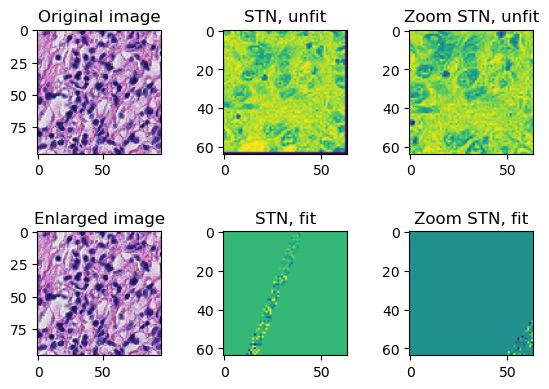

In [17]:

def plot():
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
    ax1.imshow(image, cmap='gray') 
    ax1.set_title('Original image')
    ax4.imshow(image)
    ax4.set_title('Enlarged image')
    ax2.imshow(out_pre_train)
    ax2.set_title('STN, unfit')
    ax5.imshow(out_post_train)
    ax5.set_title('STN, fit')
    ax3.imshow(out_pre_train_zoom)
    ax3.set_title('Zoom STN, unfit')
    ax6.imshow(out_post_train_zoom)
    ax6.set_title('Zoom STN, fit')
    fig.subplots_adjust(wspace=0.5)
    plt.show()

plot()


In [9]:
stn_model = tf.keras.models.load_model(file_dir+'\\STN')
stn_model_zoom = tf.keras.models.load_model(file_dir+'\\STN_zoom')

print(f'Spatial transformer network model accuracy: {round(stn_model.evaluate(test_ds)[1],2)}')
print(f'Spatial transformer network model zoom accuracy: {round(stn_model_zoom.evaluate(test_ds)[1],2)}')

7/7 [==============================] - 1s 31ms/step - loss: 0.6932 - accuracy: 0.5122
Spatial transformer network model accuracy: 0.51
7/7 [==============================] - 1s 30ms/step - loss: 0.6932 - accuracy: 0.5122
Spatial transformer network model zoom accuracy: 0.51


# *# Heat Map* 

In [6]:
#Load the different models

# tf.keras.models.save_model(spatial_transformer_model,r'/content/drive/MyDrive/Colab Notebooks/Spatial_CNN_',save_format='tf')


# model = tf.keras.models.load_model(r'/content/drive/MyDrive/Colab Notebooks/Transfer_learning_CNN')

model = tf.keras.models.load_model(r'C:\Users\mikae\Anvendt maskinelearing eksamen\Regu_l1_CONV')


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 45, 45, 64)       2

In [7]:
def get_heatmap(category, start_image):
    frog_output     = model.get_layer('dense_1').output # output layer
    last_conv_layer = model.get_layer('conv2d_2').output # deep convolution 
    
    # we could use something else
    submodel = tf.keras.models.Model([model.get_layer('resnet50').inputs], [frog_output, last_conv_layer])

    input_img_data = start_image.copy()
    input_img_data = tf.Variable(tf.cast(input_img_data, tf.float32))

    with tf.GradientTape() as tape:
        outputs_class, outputs_conv = submodel(input_img_data)
        loss_value                  = tf.reduce_mean(outputs_class[:, category])

    grads = tape.gradient(loss_value, outputs_conv)

    cast_outputs_conv = tf.cast(outputs_conv > 0, "float32")
    cast_grads        = tf.cast(grads > 0, "float32")
    guided_grads      = cast_outputs_conv * cast_grads * grads
    outputs_conv      = outputs_conv[0]
    guided_grads      = guided_grads[0]
    
    weights           = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam               = tf.reduce_sum(tf.multiply(weights, outputs_conv), axis=-1)
    
    return cam

In [8]:
from PIL import Image
cmap = plt.get_cmap('jet')

def create_heatmap(idx):
    category, image =  y_train[idx], x_train.numpy()[idx:(idx + 1)]

    heatmap = get_heatmap(category, image)
    heatmap = heatmap.numpy()
    heatmap = Image.fromarray(heatmap)
    # heatmap = heatmap.resize((96, 96), Image.ANTIALIAS)
    heatmap = heatmap.resize((96, 96), Image.LANCZOS)
    heatmap = np.array(heatmap) # back to numpy array
    heatmap = (heatmap / heatmap.max()) # to [0, 1]    
    heatmap = cmap(heatmap)
    heatmap = np.delete(heatmap, 3, 2)

    overlayed_heatmap = 0.6 * image[0] + 0.4 * heatmap
    
    return image[0], heatmap, overlayed_heatmap

def plot_heatmap():
    plt.figure(figsize=(10, 10))
    for i in range(3):
        images = create_heatmap(i)
        for j in range(3):
            ax = plt.subplot(3, 3, i * 3 + 1 + j); plt.axis('off'); plt.imshow(images[j])
    plt.show()

In [9]:
def get_label(dataset):
    """summary
    Args:
        dataset (DataSet): Takes a dataset as input and returns the labels from y axis
    Returns:
        x: All x from tensorflow dataset
    """
    return tf.convert_to_tensor([y for _, y in dataset.unbatch()],dtype=tf.float16)

def get_image(dataset):
    """summary
    Args:
        dataset (DataSet): Takes a dataset as input and returns the images from x axis
    Returns:
        y: All y from tensorflow dataset
    """
    return tf.convert_to_tensor([x for x,_  in dataset.unbatch()],dtype=tf.float16)

def get_image_and_label(dataset):
    """summary
    Args:
        dataset (DataSet): Takes a dataset as input and returns the images and labels
    Returns:
        x: All x from tensorflow dataset
        y: All y from tensorflow dataset
    """
    return get_image(dataset), get_label(dataset)

    
def get_label_from_array(array):
    label = []
    for i in range(len(array)):
        if array[i][0] == 1:
            label.append(0)
        else:
            label.append(1)
    return label

In [ ]:

#get label from train_ds
y_train = get_label(train_ds)
y_train = get_label_from_array(y_train)
y_train = np.array(y_train)
#get image from train_ds
x_train = get_image(train_ds)


In [ ]:
plot_heatmap()